# Opinion leader mining with Shell Decomposition

100%|██████████| 63734/63734 [00:45<00:00, 1414.39it/s]


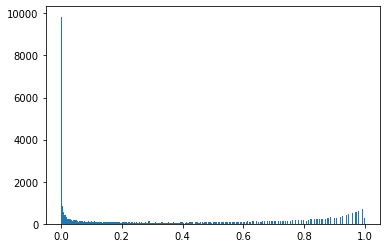

In [8]:
from dataloader import dataloader
from shellAlgorithms import *
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

dataloader = dataloader()
G = dataloader.path2nx(dataPath = 'NL_COVID19_altmetric_Twitter_data.xlsx', 
                           sheetName = ['tweets', 'tweeters'], 
                           graphRelation = ['replied', 'retweeted', 'quoted'], 
                           attributeName = 'numFollower', 
                           beta = 0.00018)

In [9]:
len(G.nodes())

38773

In [10]:
def runSIRModel(topNumber, rank):
    '''
    run SIR model on the graph, 
    '''
    rankSorted = sorted(rank.items(), key=lambda x:x[1])[::-1]
    influencialNodes = [rankSorted[i][0] for i in range(topNumber) if rankSorted[i][0] != 'extraLeaderNode']

    return dataloader.runSIR(epoches = 50, 
           tau = 0.98, 
           gamma = 0.02, 
           influencialNodes = influencialNodes, 
           tmax = float('inf'), 
           transmissionWeight = 'weight')

In [11]:
# RIFPS
rankRifpsFF = randomizedInfluencePathsSelection(G, 0.07, 1, 50, False, False)
rankRifpsTF = randomizedInfluencePathsSelection(G, 0.47, 1, 50, True, False)
rankRifpsTT = randomizedInfluencePathsSelection(G, 0.3, 1, 50, True, True)
rankRifpsFT = randomizedInfluencePathsSelection(G, 0.07, 1, 50, False, False)
# soft Decomposition
# with uniform alphas
rankIdF = softDecomposition(G, 'numFollower', False)[1]
# without uniform alphas
rankIdT = softDecomposition(G, 'numFollower', True)[1]
# leader rank
rankLR = leaderRank(Graph = G, alpha = 0.85, weightName = 'weight', withWeight = False)
# mixed degree decomposition
rankMMD = mixedDegreeDecomposition(G, 0.9, False)[1]
# k shell iteration factor
rankKsif = kShellIterationFactor(G)[1]

In [6]:
rank_list = [rankRifpsFF, rankRifpsTF, rankRifpsTT, 
             rankRifpsFT, rankIdT,  rankIdF, 
             rankLR, rankMMD, rankKsif]

rank_name = ['rankRifpsFF', 'rankRifpsTF', 'rankRifpsTT', 
             'rankRifpsFT', 'rankIdT',  'rankIdF', 
             'rankLR', 'rankMMD', 'rankKsif']

scores = []
topNumbers = []
for i in range(len(rank_list)):
    scores.append([])
    topNumbers.append([])
    
    for j in range(25):
        scores[-1].append(runSIRModel(40 * j + 1, rank_list[i]))
        topNumbers[-1].append(50 * j + 1)


<Figure size 1080x1080 with 0 Axes>

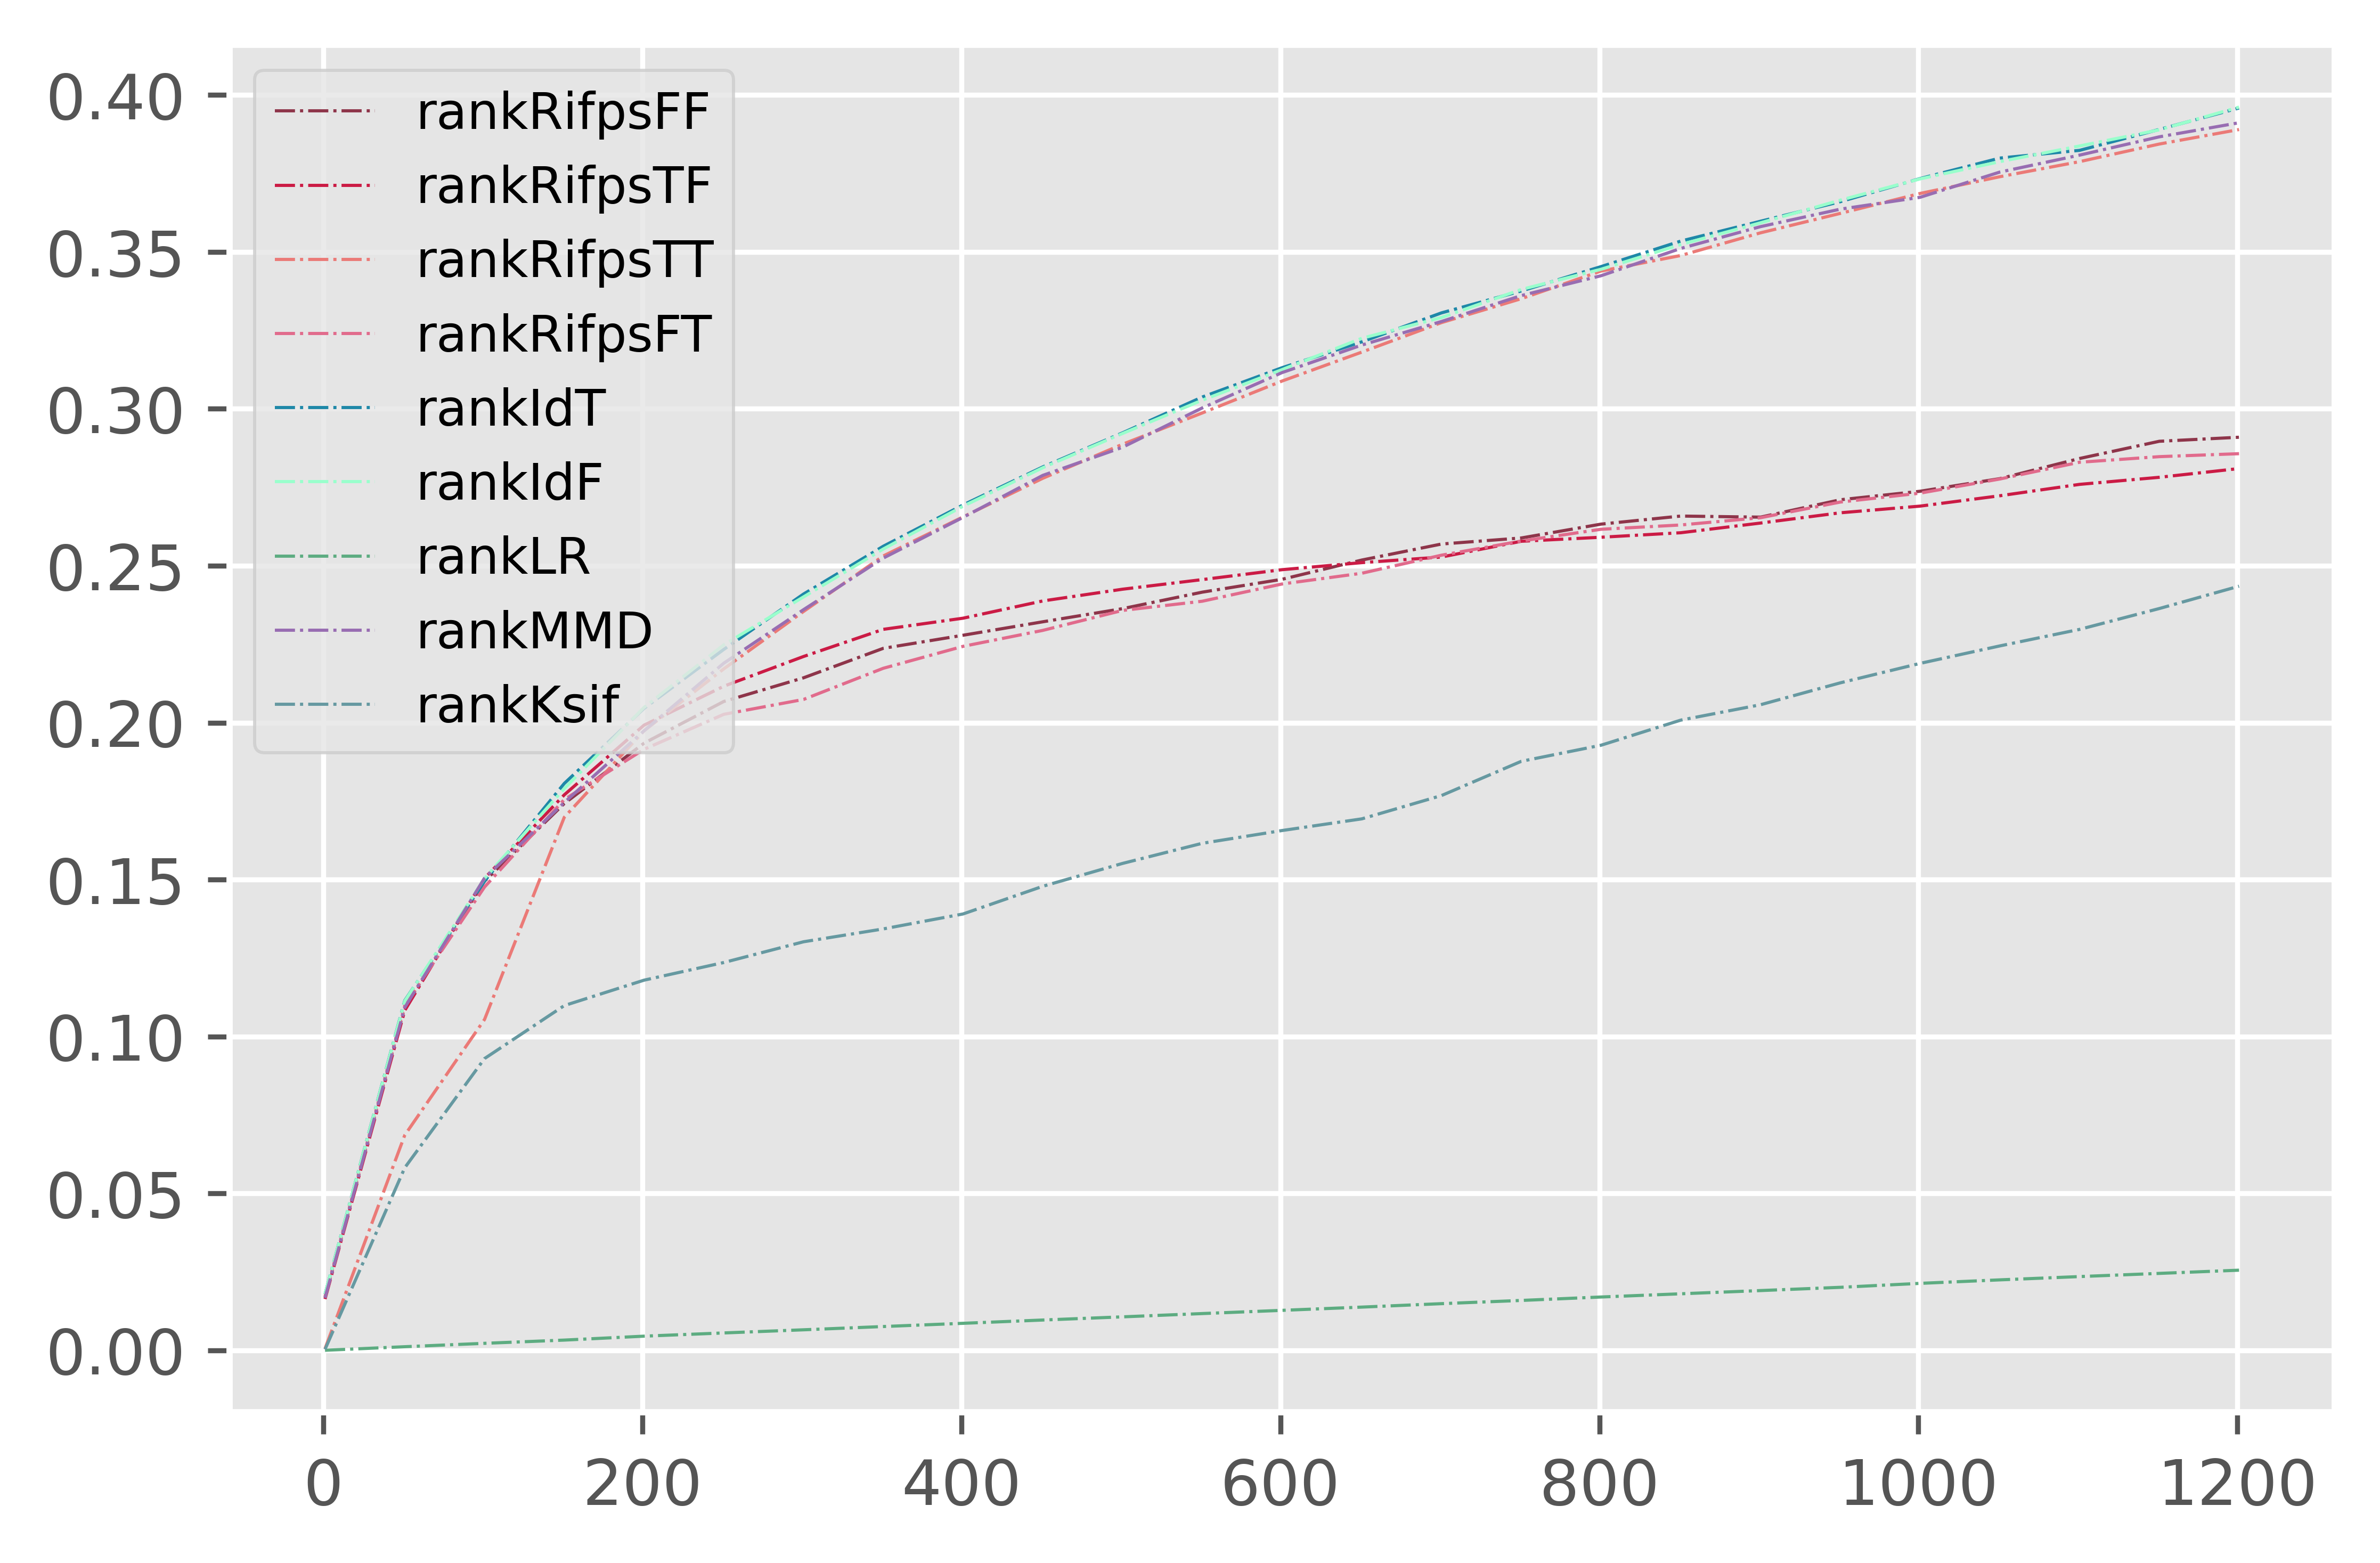

In [7]:
# plt settings
plt.figure(figsize=(15, 15))
plt.figure(dpi = 850)
colors = ['#8E354A','#CB1B45','#EB7A77','#E16B8C','#1E88A8','#99FFCC','#5DAC81','#986DB2','#6699A1']
plt.style.use('ggplot')

for i in range(len(rank_list)):
    plt.plot(topNumbers[i], scores[i], '-.', c = colors[i], label = rank_name[i], linewidth = 0.5)
    
plt.legend(loc=2, fontsize = 8)

<Figure size 1296x648 with 0 Axes>

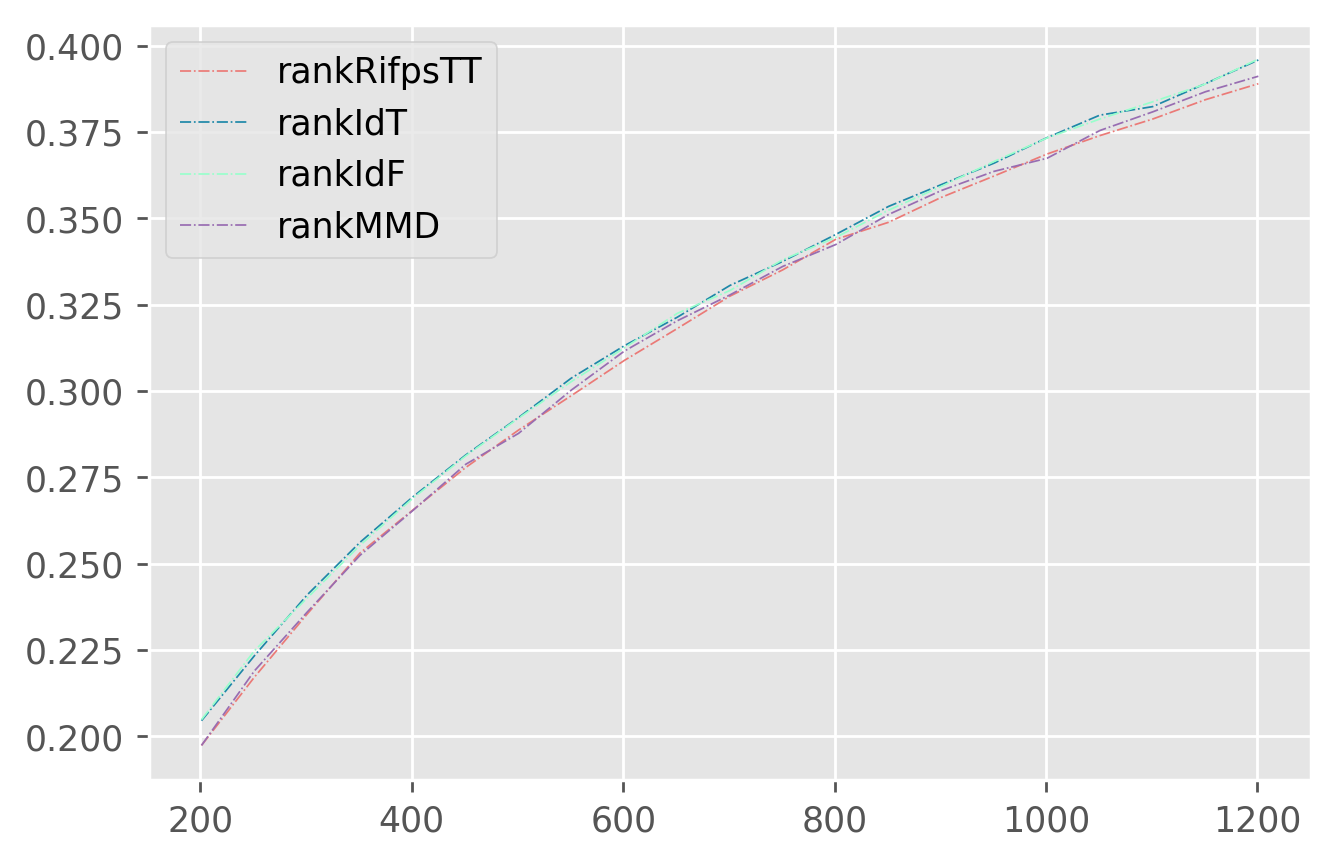

In [8]:
plt.figure(figsize=(18, 9))
plt.figure(dpi=250)
colors = ['#8E354A','#CB1B45','#EB7A77','#E16B8C','#1E88A8','#99ffcc','#5DAC81','#986DB2','#6699A1']
plt.style.use('ggplot')
for i in [2, 4, 5, 7]:
    plt.plot(topNumbers[i][4:], scores[i][4:], '-.', c = colors[i], label = rank_name[i], linewidth = 0.5)
    
plt.legend(loc=2, fontsize = 10)

In [74]:
import numpy as np
from dataloader import readData
import random

def findAllNodeByPaperID(dataPath):
    '''
    find node by paperID
    ------------
    dataPath: path of dataset
    '''
    ans = dict()
    
    dfDict = readData(dataPath, ['with paperID'])
    dfWithPaperID = dfDict['with paperID']
    
    paperIDList = np.array(dfWithPaperID['altmetric_id'].to_list())
    paperIDs = set(paperIDList[np.logical_not(np.isnan(paperIDList))])
    # get papaerID set
    
    for paperID in paperIDs:
        dfID = dfWithPaperID[(dfWithPaperID['altmetric_id'] == paperID)]
        tweets = dfID['tweet_id'].to_list()
        ans[paperID] = tweets
    
    return ans

def plotByPaperID(paperIDs, nodeRank, nodeDictByPaperID):
    '''
    paperID: paper ID
    nodeRank: 
    topNumber: top Nodes number
    '''
    
    plt.figure(dpi = 850)
    plt.style.use('ggplot')
    ax = plt.gca(projection='polar')
    ax.set_rlabel_position(0.0)  
    ax.set_rlim(0.0, 1.0)
    colors = ['#344CB7',
              '#f5ed51',
              '#EA5C2B',
              '#FF6464',
              '#E60965'
             ]
    nodeAngle, nodeR = [], []
    for node in nodeRank.keys():
        nodeR.append(np.exp(- nodeRank[node] + 0.95))
        nodeAngle.append(random.uniform(0, 360))
    plt.scatter(nodeAngle, nodeR,  c = 'grey', s=.5)
    
    i = 0
    for paperID in paperIDs:
        nodePaperAngle, nodePaperR, size = [], [], []
        for node in nodeDictByPaperID[paperID]:
            if node in nodeRank.keys():
                nodePaperR.append(np.exp(- nodeRank[node] + 0.95))
                nodePaperAngle.append(random.uniform(0, 360))
                size.append((1.05 - nodePaperR[-1]) * 10)
                
        plt.scatter(nodePaperAngle, nodePaperR,c = colors[i] , s=size, label = str(paperID) + ' rank: ' + str(i))
        i += 1
    # plotting
    plt.legend(loc=(0.9, 0), fontsize = 6)
    plt.show()
    return 0

def findInfluentialPaper(topNumber, nodeRank, nodeDictByPaperID):
    ans = dict()
    for paperID in nodeDictByPaperID.keys():
        ranks = list()
        for node in nodeDictByPaperID[paperID]:
            if node in nodeRank.keys():
                ranks.append(nodeRank[node])
        ans[paperID] = (sum(ranks) - len(ranks)) 
        # / (1 + len(ranks))
        
    rankSorted = sorted(ans.items(), key=lambda x:x[1])[::-1]   
    influencialNodes = [rankSorted[i][0] for i in range(topNumber) if rankSorted[i][0] != 'extraLeaderNode']
    
    return influencialNodes, ans
    

In [51]:
nodeDictByPaperID = findAllNodeByPaperID('Influential tweets with paperID.xlsx')
influentialPaper

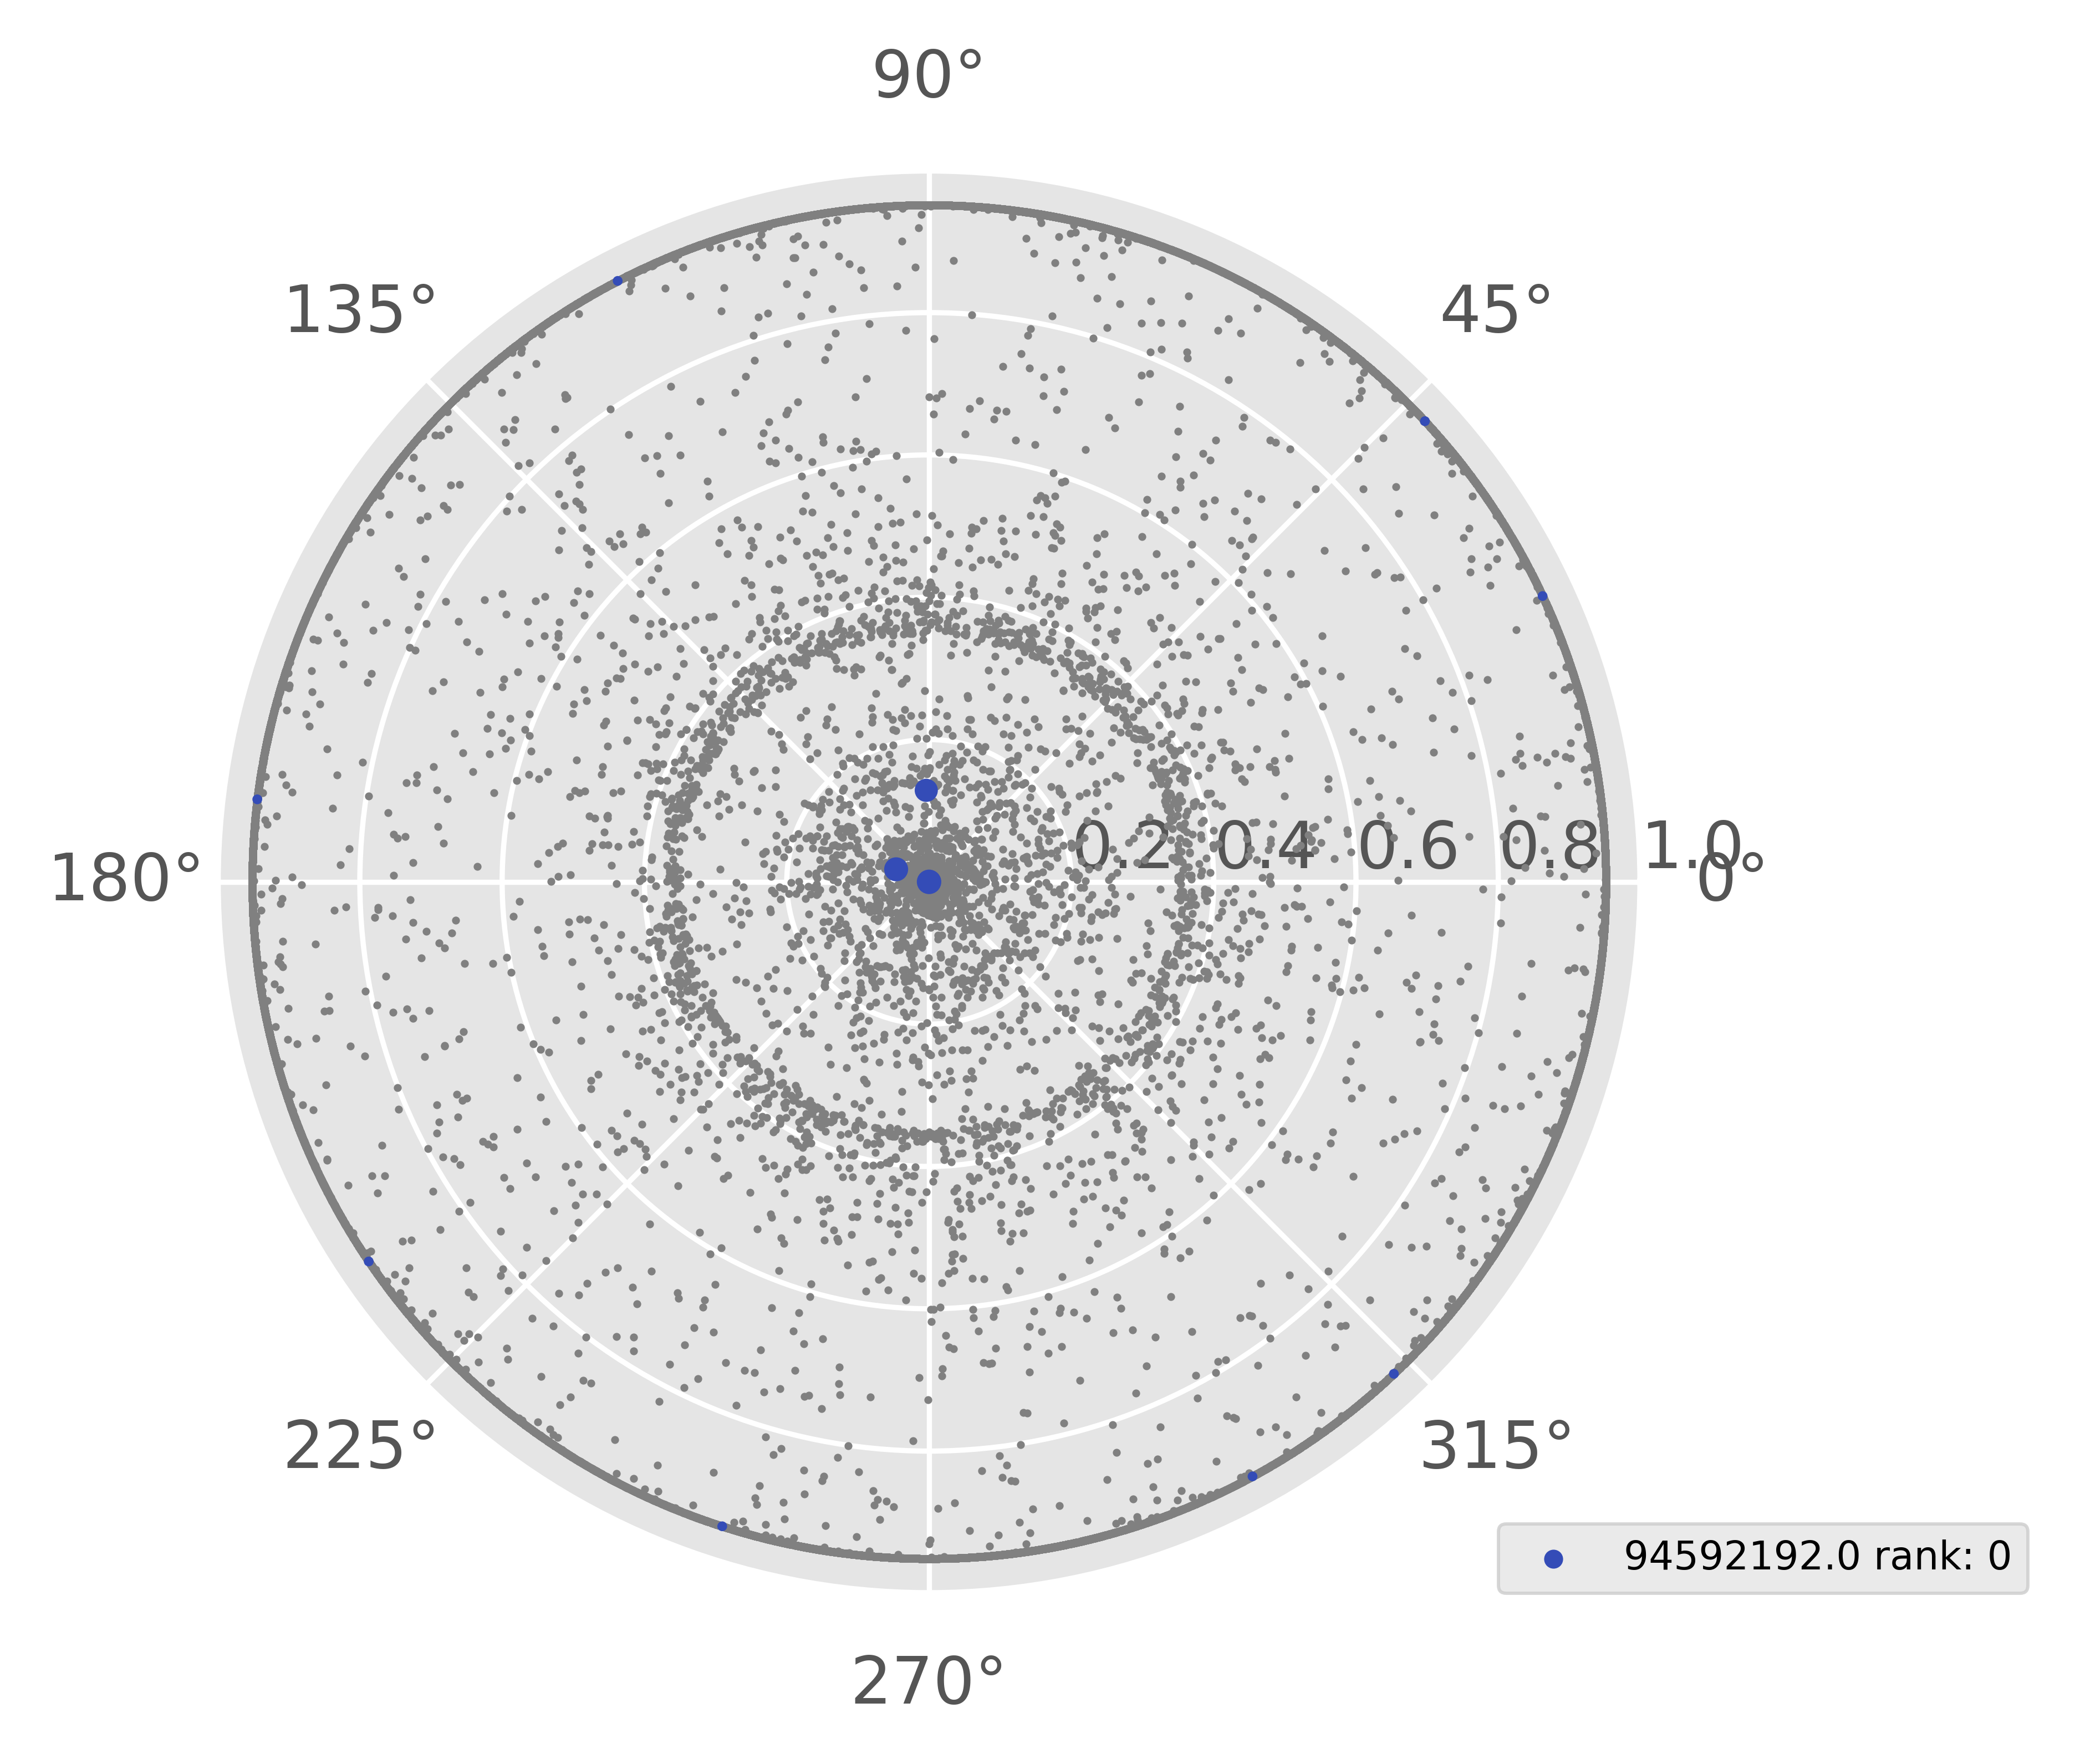

0

In [75]:
influentialPaper, paperRank1 = findInfluentialPaper(10, rankIdT, nodeDictByPaperID)
plotByPaperID(influentialPaper[:5], rankIdF, nodeDictByPaperID)

In [59]:
paperRank2

{85819400.0: 0.0,
 77365258.0: 0.0,
 85557264.0: 0.0,
 93093913.0: 0.6499174274557464,
 81559593.0: 0.0,
 86114361.0: 0.0,
 91947071.0: 0.0,
 94175319.0: 0.3985400911930379,
 77693017.0: 0.0,
 44204123.0: 0.0,
 97779812.0: 0.5944202263106857,
 76677225.0: 0.1811649782970446,
 90898542.0: 0.0,
 75956336.0: 0.0,
 97779840.0: 0.0,
 80838786.0: 0.9111013528715404,
 94142603.0: 0.018156127343507245,
 95256717.0: 0.0,
 95584405.0: 0.0,
 84607133.0: 0.0,
 77627550.0: 1.3250460237519885,
 94175410.0: 0.0,
 92602560.0: 0.0,
 29524187.0: 0.0,
 86835427.0: 0.0,
 89260260.0: 0.0,
 94175464.0: 0.0,
 97321203.0: 0.15743427954014377,
 88506625.0: 0.0,
 75563273.0: 0.0,
 80380178.0: 0.17762046001328877,
 85754136.0: 0.6085823569104116,
 94667033.0: 0.0,
 85393691.0: 0.0,
 92963104.0: 0.0,
 80707882.0: 0.0,
 80019763.0: 0.0,
 90276148.0: 0.4575435840929951,
 88408373.0: 0.0,
 90079549.0: 0.0,
 88867138.0: 0.0,
 89915718.0: 0.0,
 85754186.0: 0.0,
 78643534.0: 0.0,
 557405.0: 0.0,
 80806238.0: 9.81128803

In [7]:
def IoU(rank1, rank2, topNumber):
    rank1Sorted = sorted(rank1.items(), key=lambda x:x[1])[::-1]   
    influencialNodes1 = [rank1Sorted[i][0] for i in range(topNumber) if rank1Sorted[i][0] != 'extraLeaderNode']
    
    rank2Sorted = sorted(rank2.items(), key=lambda x:x[1])[::-1]   
    influencialNodes2 = [rank2Sorted[i][0] for i in range(topNumber) if rank2Sorted[i][0] != 'extraLeaderNode']
    
    return len(set(influencialNodes1) & set(influencialNodes2))/len(set(influencialNodes1) | set(influencialNodes2))

rank_list = [rankRifpsFF, rankRifpsTF, rankRifpsTT, 
             rankRifpsFT, rankIdT,  rankIdF, 
             rankLR, rankMMD, rankKsif]
rank_name = ['rankRifpsFF', 'rankRifpsTF', 'rankRifpsTT', 
             'rankRifpsFT', 'rankIdT',  'rankIdF', 
             'rankLR', 'rankMMD', 'rankKsif']

heatmap1 = []
for i in range(9):
    heatmap1.append([])
    for j in range(9):
        heatmap1[i].append(IoU(rank_list[i], rank_list[j], 50))
        

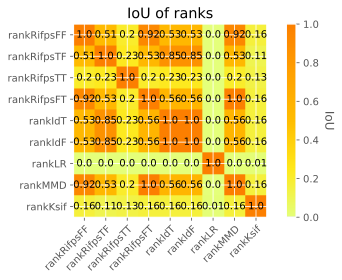

In [8]:
cbarlabel="IoU"
heatmap = np.array(heatmap1)
%config InlineBackend.figure_format='svg'#输出矢量图设置

fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap="Wistia")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(rank_name)))
ax.set_xticklabels(labels=rank_name)

ax.set_yticks(np.arange(len(rank_name)))
ax.set_yticklabels(labels=rank_name)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(rank_name)):
    for j in range(len(rank_name)):
        text = ax.text(j, i, int(100*heatmap[i, j])/100,
                       ha="center", va="center", color="black")
        

        
ax.set_title("IoU of ranks")
fig.tight_layout()
plt.show()

In [23]:
import pickle
pickle.dump(paperRankAll, open( "paperRankAll.p", "wb" ) )

In [22]:
paperRankAll = {'rankWithoutAverage': paperRank, 'rankWithAverage': paperRank2}

In [5]:
import pickle
print(pickle.format_version)

4.0


In [76]:
import pandas as pd
tweetDataframe = pd.DataFrame(np.array(list(rankIdT.items())), columns = ['tweet_id', 'rank'])
paperDataframe1 = pd.DataFrame(np.array(list(paperRank1.items())), columns = ['paper_id', 'rank_with_sum'])
paperDataframe2 = pd.DataFrame(np.array(list(paperRank2.items())), columns = ['paper_id', 'rank_with_average'])

In [79]:
tweetDataframe.to_csv(r'tweet_rank.csv', index = False, header = True)
paperDataframe1.to_csv(r'paper_rank_with_sum.csv', index = False, header = True)
paperDataframe2.to_csv(r'tweet_rank_with_average.csv', index = False, header = True)

In [71]:
paperRank1[80806238.0]

1.962257607512896e-07

In [70]:
paperRank2[80806238.0]

9.81128803756448e-08